In [ ]:
!apt install cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cuda-11-5 cuda-cccl-11-5 cuda-command-line-tools-11-5 cuda-compiler-11-5
  cuda-cudart-11-5 cuda-cudart-dev-11-5 cuda-cuobjdump-11-5 cuda-cupti-11-5
  cuda-cupti-dev-11-5 cuda-cuxxfilt-11-5 cuda-demo-suite-11-5
  cuda-documentation-11-5 cuda-driver-dev-11-5 cuda-gdb-11-5
  cuda-libraries-11-5 cuda-libraries-dev-11-5 cuda-memcheck-11-5
  cuda-nsight-11-5 cuda-nsight-compute-11-5 cuda-nsight-systems-11-5
  cuda-nvcc-11-5 cuda-nvdisasm-11-5 cuda-nvml-dev-11-5 cuda-nvprof-11-5
  cuda-nvprune-11-5 cuda-nvrtc-11-5 cuda-nvrtc-dev-11-5 cuda-nvtx-11-5
  cuda-nvvp-11-5 cuda-runtime-11-5 cuda-samples-11-5 cuda-sanitizer-11-5
  cuda-toolkit-11-5 cuda-toolkit-11-5-config-common
  cuda-toolkit-11-config-common cuda-toolkit-config-common cuda-tools-11-5
  cuda-visual-tools-11-5 gds-tools-11-5 libcublas-11-5 libcublas-dev-11-5
  libcufft-11-5 libcufft-d

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import os
import json
import zipfile
import time
import itertools

import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import numpy as np

plt.style.use('seaborn')
import random

import math
import pdb

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from pytorch_forecasting.metrics import MAE, RMSE, MAPE

warnings.filterwarnings('ignore')


def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()."""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 11 19:02:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
travel_time_df = pd.read_csv('/content/drive/MyDrive/CIS 545 Project Folder/Data Set/2021_travel_time.csv')
corridor_file = "/content/drive/MyDrive/CIS 545 Project Folder/Data Set/pems_district4_corridors.csv"
corridor_df = pd.read_csv(corridor_file)

travel_time_df = travel_time_df[travel_time_df['5 Minutes'] > '2021-1-01 00:00:00']

In [ ]:
corridors_to_merge = []

for row_num, corridor in corridor_df.iterrows():  	
      if row_num == 0:
          all_corridors_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
      else:
          corridor_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
          all_corridors_tt_2021 = all_corridors_tt_2021.merge(corridor_tt_2021, "outer", left_on='5 Minutes', right_on='5 Minutes')

In [ ]:
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,...,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y
0,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
1,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
2,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
3,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
4,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.35,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,2021-10-31 23:55:00,10.88,11.60,NaN,NaN,NaN,5.33,3.93,3.85,6.58,6.73,NaN,1.87,10.78,10.60,21.62,21.37,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,16.75,16.45,10.78,10.95,6.43,7.02,16.57,16.53,4.12,4.25,3.57,3.52,NaN,NaN,10.83,...,17.18,17.52,12.40,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.95,13.97,15.32

In [ ]:
all_corridors_tt_2021 = all_corridors_tt_2021.dropna(axis=1)
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y
0,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
1,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
2,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
3,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
4,2021-10-01 00:00:00,10.90,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55868,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55869,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55870,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72


In [ ]:
new_columns = [f"travel_time_{n}" for n in range(len(all_corridors_tt_2021.columns) - 1)]
new_columns.insert(0, "timestamp")
# len(new_columns)
all_corridors_tt_2021 = all_corridors_tt_2021.set_axis(new_columns, axis=1, inplace=False)
num_records, num_corridors = all_corridors_tt_2021.shape

In [ ]:
all_corridors_tt_2021.head(10)

,timestamp,travel_time_0,travel_time_1,travel_time_2,travel_time_3,travel_time_4,travel_time_5,travel_time_6,travel_time_7,travel_time_8,travel_time_9,travel_time_10,travel_time_11,travel_time_12,travel_time_13,travel_time_14,travel_time_15,travel_time_16,travel_time_17,travel_time_18,travel_time_19,travel_time_20,travel_time_21,travel_time_22,travel_time_23,travel_time_24,travel_time_25,travel_time_26,travel_time_27,travel_time_28,travel_time_29,travel_time_30,travel_time_31,travel_time_32,travel_time_33,travel_time_34,travel_time_35,travel_time_36,travel_time_37,travel_time_38,travel_time_39,travel_time_40
0,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
1,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
2,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
3,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
4,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
5,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
6,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
7,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
8,2021-10-01 00:05:00,10.9,11.58,5.32,10.62,4.15,4.23,1.28,1.25,13.38,13.05,6.47,6.08,4.22,4.63,3.57,3.57,27.75,11.93,11.98,12.02,7.62,17.98,14.83,3.22,3.30,12.43,12.33,8.28,8.20,17.13,12.17,13.92,13.93,18.33,18.78,25.48,25.58,5.75,6.08,15.70,15.80
9,2021-10-01 00:05:00,10.9,11.58,5.32,10.62,4.15,4.23,1.28,1.25,13.38,13.05,6.47,6.08,4.22,4.63,3.57,3.57,27.75,11.93,11.98,12.02,7.62,17.98,14.83,3.22,3.30,12.43,12.33,8.28,8.20,17.13,12.17,13.92,13.93,18.33,18.78,25.48,25.58,5.75,6.08,15.70,15.80


In [ ]:
def make_dataset_many_to_one(array,time_steps, num_sample, Horizon = 0):

    x = []
    y = []

    indices = random.sample(range(time_steps, len(array) - Horizon), num_sample)

    for i in indices:
        x.append(array[i-time_steps:i])
        y.append(array[i + Horizon])
        
    return np.array(x), np.array(y)

# train_data = all_corridors_tt_2021.drop(['timestamp'], axis=1).iloc[:num_training]
total_data = all_corridors_tt_2021.drop(['timestamp'], axis=1)
 #for testing at bottom
print(total_data)

       travel_time_0  travel_time_1  ...  travel_time_39  travel_time_40
0              10.90          11.55  ...           15.75           15.78
1              10.90          11.55  ...           15.75           15.78
2              10.90          11.55  ...           15.75           15.78
3              10.90          11.55  ...           15.75           15.78
4              10.90          11.55  ...           15.75           15.78
...              ...            ...  ...             ...             ...
55867          10.88          11.60  ...           15.70           15.72
55868          10.88          11.60  ...           15.70           15.72
55869          10.88          11.60  ...           15.70           15.72
55870          10.88          11.60  ...           15.70           15.72
55871          10.88          11.60  ...           15.70           15.72

[55872 rows x 41 columns]


In [ ]:
#scale values to [0,1]
num_training = 12000
num_validate = 4000
num_test = 4000
time_steps = 24  # 2 hours
num_corridor = total_data.shape[1]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit_transform(total_data)
# train = scaler.transform(train_data)
total = scaler.transform(total_data)

sc = MinMaxScaler()
total_data = sc.fit_transform(total_data)

## 15 minutes horizon
trn_x_15min, trn_y_15min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 2)  #every 2 hours.
vld_x_15min, vld_y_15min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 2)  #every 2 hours.
tst_x_15min, tst_y_15min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 2)  #every 2 hours.

trn_x_15min = trn_x_15min.reshape(-1,time_steps, num_corridor)
vld_x_15min = vld_x_15min.reshape(-1,time_steps, num_corridor)
tst_x_15min = tst_x_15min.reshape(-1,time_steps, num_corridor)


## 30 minutes horizon
trn_x_30min, trn_y_30min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 5)  #every 2 hours.
vld_x_30min, vld_y_30min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 5)  #every 2 hours.
tst_x_30min, tst_y_30min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 5)  #every 2 hours.

trn_x_30min = trn_x_30min.reshape(-1,time_steps, num_corridor)
vld_x_30min = vld_x_30min.reshape(-1,time_steps, num_corridor)
tst_x_30min = tst_x_30min.reshape(-1,time_steps, num_corridor)


## 45 minutes horizon
trn_x_45min, trn_y_45min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 8)  #every 2 hours.
vld_x_45min, vld_y_45min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 8)  #every 2 hours.
tst_x_45min, tst_y_45min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 8)  #every 2 hours.

trn_x_45min = trn_x_45min.reshape(-1,time_steps, num_corridor)
vld_x_45min = vld_x_45min.reshape(-1,time_steps, num_corridor)
tst_x_45min = tst_x_45min.reshape(-1,time_steps, num_corridor)


In [ ]:
# conver the data to tensors and pass to the Dataloader 
# to create an batch iterator
from torch.utils.data import Dataset, DataLoader

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
# A custom attention layer
class SelfAttention(nn.Module):
    def __init__(self, attention_size, att_hops, non_linearity="tanh"):
        super(SelfAttention, self).__init__()

        self.ut_dense =  nn.Sequential(
                nn.Linear(hidden_size, attention_size),
                nn.Tanh()
         )
        
        self.et_dense = nn.Linear(attention_size, att_hops)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):

        ##################################################################
        # STEP 1 - perform dot product
        # of the attention vector and each hidden state
        ##################################################################

        # inputs is a 3D Tensor: batch, len, hidden_size
        # scores is a 2D Tensor: batch, len
        ut = self.ut_dense(inputs)

        # et shape: [batch_size, seq_len, att_hops]
        et = self.et_dense(ut)

        att_scores = self.softmax(torch.permute(et, (0, 2, 1)))

        # # re-normalize the masked scores
        # _sums = scores.sum(-1, keepdim=True)  # sums per row
        # att_scores = scores.div(_sums)  # divide by row sum

        ##################################################################
        # Step 2 - Weighted sum of hidden states, by the attention scores
        ##################################################################
        
        # print("att_scores.shape: ", att_scores.shape, "inputs.shape", inputs.shape)

        # multiply each hidden state with the attention weights
        output = torch.bmm(att_scores, inputs)

        return output, att_scores

In [ ]:
# A custom attention layer
# class SelfAttention(nn.HybridBlock):
#     def __init__(self, att_unit, att_hops, **kwargs):
#         super(SelfAttention, self).__init__(**kwargs)
#         with self.name_scope():
#             self.ut_dense = nn.Dense(att_unit, activation='tanh', flatten=False)

#         # # output layer
#         # self.output_layer =  nn.Sequential(
#         #     nn.Linear(hidden_size, nfc),
#         #     nn.ReLU(),
#         #     nn.Dropout(drop_prob),
#         #     nn.Linear(nfc, nfc),
#         #     nn.ReLU(), 
#         #     nn.Dropout(drop_prob),
#         #     nn.Linear(nfc, num_corridor),
#         # )

#         self.et_dense = nn.Dense(att_hops, activation=None, flatten=False)

#     def hybrid_forward(self, F, x):
#         # x shape: [batch_size, seq_len, LSTM_nhidden]
#         # ut shape: [batch_size, seq_len, att_unit]
#         ut = self.ut_dense(x)
#         # et shape: [batch_size, seq_len, att_hops]
#         et = self.et_dense(ut)

#         # att shape: [batch_size,  att_hops, seq_len]
#         att = F.softmax(F.transpose(et, axes=(0, 2, 1)), axis=-1)  
#         # output shape [batch_size, att_hops, LSTM_nhidden]
#         output = F.batch_dot(att, x)

#         return output, att

In [ ]:
"""
Attention mechanism in Hierarchical LSTM
"""

class HierLstm(nn.Module):

    def __init__(self, num_corridor, hidden_size, num_layers, natt_unit, natt_hops, nfc, drop_prob):
        super(HierLstm, self).__init__()

        self.input_size = num_corridor
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.fc_hidden_size = hidden_size * num_layers

        # default maximum upgrade length
        self.up_len = 80

        # bottom layer of LSTM
        self.lstm = nn.LSTM(num_corridor, hidden_size, num_layers, batch_first=True)                 

        # attention layer
        self.att_encoder = SelfAttention(natt_unit, natt_hops)      

        # flattern
        self.handle_hops = nn.Sequential(
            nn.Flatten()
            )

        # output layer
        self.output_layer =  nn.Sequential(
            nn.Linear(hidden_size * natt_hops, nfc),
            nn.ReLU(),
            nn.Linear(nfc, num_corridor)
        )

        self.fc = nn.Linear(self.fc_hidden_size, num_corridor)

    def forward(self, x):
        lstm_output, (h_out, _) = self.lstm(x)  # output, (hidden, cell) = lstm(input_data, begin_state)
        # print("lstm_output shape", lstm_output.shape)  #(batch, sequence, hidden)
        # h_out size (number_layers, batch, hidden_size)
        # print("h_out size: ", h_out.shape)
        output = None   # output of VLAttHierLstm

        seq_len = x.shape[1]
        batch_Size = x.shape[0]
        # print("seq_len: ", seq_len, "  ", "batch_Size: ", batch_Size)
        
        # set upgrade length
        up_len = min(self.up_len, math.floor(math.sqrt(seq_len)))
        # evenly spaced index
        idx = np.linspace(up_len - 1, math.pow(up_len, 2) - 1, num = up_len)
        # print(idx)

        if idx[-1] == seq_len - 1:
            idx.remove(seq_len - 1)

        # Hierarchical from lstm
        # up_x = torch.cat([lstm_output[:, int(i), :] for i in idx])
        up_x = torch.stack([lstm_output[:, int(i), :] for i in idx])
        # append the last output of bottom lstm
        # if idx[-1] != seq_len - 1:
        #     up_x = torch.cat((up_x, lstm_output[:, -1, :]))
        # up_x.append([h_out[layer_num,:,:] for layer_num in range(h_out.shape[0])])

        up_x = torch.cat((up_x, h_out))  # size: (sample, batch, hiddensize)
        up_x = torch.transpose(up_x, 1, 0)   # size: (batch, sample, hiddensize)
        # print("up_x.shape: ", up_x.shape)   # up_x.shape:  torch.Size([250, 120])
        # print("reshaped up_x: ", up_x.view(batch_Size, -1, self.hidden_size).shape)   # reshaped up_x:  torch.Size([batch_size, sample_Size, hidden_size])

        att_output, att_scores = self.att_encoder(up_x.view(batch_Size, -1, self.hidden_size))
        # att_output shape [batch_size, att_hops, LSTM_nhidden]

        att_output_flattern = self.handle_hops(att_output)  # [batch_size, att_hops * LSTM_nhidden]
        
        output = self.output_layer(att_output_flattern)

        return output


num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 2          # lstm layers
attention_size = 300     # the hidden_units of attention layer
natt_hops = 2
nfc = 512               # fully connected layer
drop_prob = 0.2         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HierLstm(num_corridor, hidden_size, num_layers, attention_size, natt_hops, nfc, drop_prob)
model = model.to(device)

learning_rate =  0.001

num_epochs = 1000

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 15 minutes Horizon

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_15min)))
trainY = Variable(torch.Tensor(np.array(trn_y_15min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_15min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_15min)))

testX = Variable(torch.Tensor(np.array(tst_x_15min)))
testY = Variable(torch.Tensor(np.array(tst_y_15min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss_15min, val_loss_15min = [], []

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss_15min.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/hiLSTMat_15min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            y_pred = sc.inverse_transform(y_pred)
            targets = sc.inverse_transform(targets)   

            mae_test += mean_absolute_error(targets, y_pred)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss_15min.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss_15min[-1], val_loss_15min[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 0.00008358 val_loss: 0.00011291 
epoch: 20 | trn_loss: 0.00007125 val_loss: 0.00011064 
epoch: 30 | trn_loss: 0.00006485 val_loss: 0.00011105 
epoch: 40 | trn_loss: 0.00005933 val_loss: 0.00010820 
epoch: 50 | trn_loss: 0.00005828 val_loss: 0.00011367 
epoch: 60 | trn_loss: 0.00005446 val_loss: 0.00010969 
epoch: 70 | trn_loss: 0.00005291 val_loss: 0.00010918 
epoch: 80 | trn_loss: 0.00005313 val_loss: 0.00010927 
epoch: 90 | trn_loss: 0.00005028 val_loss: 0.00011144 
epoch: 100 | trn_loss: 0.00004921 val_loss: 0.00011054 
epoch: 110 | trn_loss: 0.00004984 val_loss: 0.00011140 
epoch: 120 | trn_loss: 0.00004922 val_loss: 0.00011049 
epoch: 130 | trn_loss: 0.00004585 val_loss: 0.00010949 
epoch: 140 | trn_loss: 0.00004462 val_loss: 0.00010947 
epoch: 150 | trn_loss: 0.00004369 val_loss: 0.00010759 
epoch: 160 | trn_loss: 0.00004509 val_loss: 0.00010934 
epoch: 170 | trn_loss: 0.00004527 val_loss: 0.00011218 
epoch: 180 | trn_loss: 0.00004287 val_loss: 0.00010998 
e

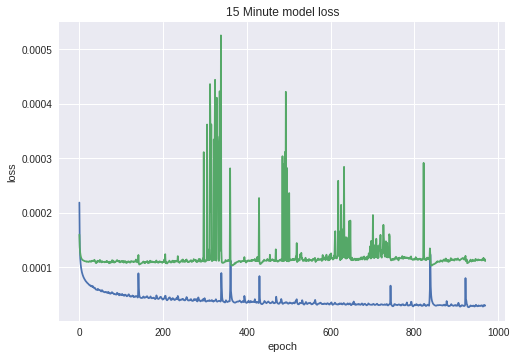

In [ ]:
plt.plot(trn_loss_15min[:-30], label = "Training Loss")
plt.plot(val_loss_15min[:-30], label = "Validating Loss")
plt.title('15 Minute model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 30 Minutes Horizon

In [ ]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 1          # lstm layers
attention_size = 300     # the hidden_units of attention layer
natt_hops = 2
nfc = 512               # fully connected layer
drop_prob = 0.5         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HierLstm(num_corridor, hidden_size, num_layers, attention_size, natt_hops, nfc, drop_prob)
model = model.to(device)

learning_rate =  0.001

num_epochs = 1000

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_30min)))
trainY = Variable(torch.Tensor(np.array(trn_y_30min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_30min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_30min)))

testX = Variable(torch.Tensor(np.array(tst_x_30min)))
testY = Variable(torch.Tensor(np.array(tst_y_30min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/hiLSTMat_30min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            y_pred = sc.inverse_transform(y_pred)
            targets = sc.inverse_transform(targets)   

            mae_test += mean_absolute_error(targets, y_pred)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 0.00028557 val_loss: 0.00030789 
epoch: 20 | trn_loss: 0.00023284 val_loss: 0.00027587 
epoch: 30 | trn_loss: 0.00020979 val_loss: 0.00025121 
epoch: 40 | trn_loss: 0.00020388 val_loss: 0.00024180 
epoch: 50 | trn_loss: 0.00016275 val_loss: 0.00022107 
epoch: 60 | trn_loss: 0.00016004 val_loss: 0.00021212 
epoch: 70 | trn_loss: 0.00014239 val_loss: 0.00019468 
epoch: 80 | trn_loss: 0.00013795 val_loss: 0.00019463 
epoch: 90 | trn_loss: 0.00014264 val_loss: 0.00019136 
epoch: 100 | trn_loss: 0.00021174 val_loss: 0.00020617 
epoch: 110 | trn_loss: 0.00012406 val_loss: 0.00019347 
epoch: 120 | trn_loss: 0.00011798 val_loss: 0.00019940 
epoch: 130 | trn_loss: 0.00012875 val_loss: 0.00021854 
epoch: 140 | trn_loss: 0.00010342 val_loss: 0.00018270 
epoch: 150 | trn_loss: 0.00010555 val_loss: 0.00018448 
epoch: 160 | trn_loss: 0.00010675 val_loss: 0.00018722 
epoch: 170 | trn_loss: 0.00010217 val_loss: 0.00017481 
epoch: 180 | trn_loss: 0.00009663 val_loss: 0.00017489 
e

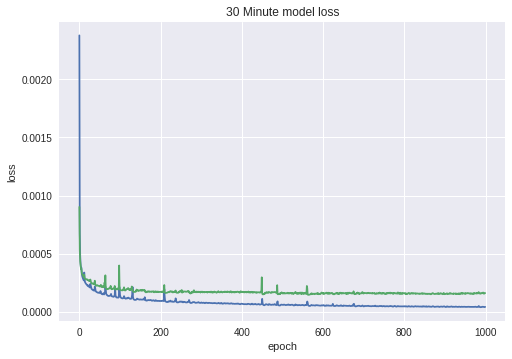

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('30 Minute model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 45 minute Horizon

In [ ]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 1          # lstm layers
attention_size = 300     # the hidden_units of attention layer
natt_hops = 2
nfc = 512               # fully connected layer
drop_prob = 0.5         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HierLstm(num_corridor, hidden_size, num_layers, attention_size, natt_hops, nfc, drop_prob)
model = model.to(device)

learning_rate =  0.001

num_epochs = 1000

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_45min)))
trainY = Variable(torch.Tensor(np.array(trn_y_45min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_45min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_45min)))

testX = Variable(torch.Tensor(np.array(tst_x_45min)))
testY = Variable(torch.Tensor(np.array(tst_y_45min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/hiLSTMat_45min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            y_pred = sc.inverse_transform(y_pred)
            targets = sc.inverse_transform(targets)   

            mae_test += mean_absolute_error(targets, y_pred)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("Best Model mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 0.00024930 val_loss: 0.00027485 
epoch: 20 | trn_loss: 0.00020612 val_loss: 0.00026557 
epoch: 30 | trn_loss: 0.00019756 val_loss: 0.00025460 
epoch: 40 | trn_loss: 0.00018729 val_loss: 0.00025235 
epoch: 50 | trn_loss: 0.00017224 val_loss: 0.00023805 
epoch: 60 | trn_loss: 0.00017143 val_loss: 0.00024041 
epoch: 70 | trn_loss: 0.00016378 val_loss: 0.00023469 
epoch: 80 | trn_loss: 0.00015770 val_loss: 0.00022618 
epoch: 90 | trn_loss: 0.00015102 val_loss: 0.00023394 
epoch: 100 | trn_loss: 0.00014133 val_loss: 0.00022602 
epoch: 110 | trn_loss: 0.00013544 val_loss: 0.00022231 
epoch: 120 | trn_loss: 0.00013460 val_loss: 0.00022190 
epoch: 130 | trn_loss: 0.00013507 val_loss: 0.00021589 
epoch: 140 | trn_loss: 0.00012480 val_loss: 0.00021693 
epoch: 150 | trn_loss: 0.00012223 val_loss: 0.00021417 
epoch: 160 | trn_loss: 0.00012017 val_loss: 0.00021504 
epoch: 170 | trn_loss: 0.00011891 val_loss: 0.00020058 
epoch: 180 | trn_loss: 0.00011600 val_loss: 0.00020668 
e

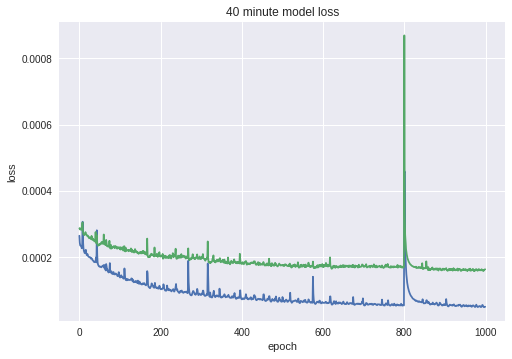

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('40 minute model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()